# Implementation of a Linear Model Classifier from scratch
## TODO
- [ ] Testing
      
      Note: produce 1 per ogni input. Sia in Val che in Test, la metà di questi sono corretti, l'altra metà no.
- [ ] Accuracy: Normalization of data
- [ ] Accuracy: find a better LBE

## Must have
* [x] Learning Algorithm: Gradient Descent
* [x] Loss Function: Least Mean Square
* [x] Version: Batch
* [x] Threshold function: Sign
* [x] Tikhonov Regularization
* [x] KFold validation
* [x] Linear Basis Expansion

## Nice to have
* [ ] Learning Algorithm: Normal Equation Solution
* [ ] Version: Stochastic and mini-batch

In [37]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
def read_ds(path):
  """
  parse CSV data set and
  returns a tuple (input, target)
  """
  df = pd.read_csv(path, sep=" ", names=['NaN','y','x1','x2','x3','x4','x5','x6','garbage'])
  y, df = df['y'], df.drop(columns=['NaN','garbage','y'])
  
  # One-hot encoding categorical variables
  df = pd.get_dummies(df, columns=['x1','x2','x3','x4','x5','x6']).astype('int')

  return (df, y)

In [3]:
# Datasets Path
TR_PATH = "./monks/datasets/monks-1.train"
TS_PATH = "./monks/datasets/monks-1.test"

# read training and test set
X_train, y_train = read_ds(TR_PATH)
X_test,  y_test  = read_ds(TS_PATH)

In [42]:
# LinearClassifier implements BaseEstimator, in order to reuse the SciKit's Kfold CV

class LinearClassifier(BaseEstimator):
  def __init__(self, learning_rate=0.01, reg_param=0.1, epochs=1000):
    self.learning_rate = learning_rate
    self.reg_param = reg_param
    self.epochs = epochs
    self.weights = None

  # Add bias to the input vector
  def add_bias(self, X):
    """ 
    Adds bias to a vector: [x1, ..., xn] -> [1, x1, ..., xn]
    For a matrix, adds a column of ones to the left handside
    """ 
    return np.c_[np.ones(X.shape[0]), X]

  # Polynomial LBE
  def to_poly(self, X):
    """
    Take a vector [x1, ..., xn] and returns its polynomial transformation [x1^1, ..., xn^n]
    """
    return np.asarray([ [ X[i][j]**j for j in range(len(X[i])) ] for i in range(len(X)) ])

  def fit(self, X, y):
    """
    Fit to the given dataset <X,y>.
    It uses the Batch version of gradient descent, with LBE and decremental learning rate
    """

    # Add bias component, apply LBE and set random initial weights vector 
    X = self.to_poly(self.add_bias(X))
    self.weights = np.random.rand(X.shape[1])
    dw = np.zeros_like(self.weights)
    
    # Batch version
    for epoch in range(self.epochs):

      # Gradient computation
      for j in range(len(self.weights)):
        s = sum( [ ( y.iloc[p] - np.dot(X[p], self.weights) ) * X[p][j] for p in range(len(X)) ] )
        dw[j] = -2/len(X) * s
      
      # update weights and learning rate
      self.weights += self.learning_rate * dw - ( 2 * self.reg_param * self.weights )
      self.learning_rate /= 10
    return self

  def predict(self, X):
    """
    returns the prediction of data X, using fitted weights
    """ 
    X = self.add_bias(X)
    predictions = X.dot(self.weights)
    return np.sign(predictions)

  def score(self, X, y):
    """ 
    computes the prediction of the data X and measures the score wrt target y
    """ 
    predictions = self.predict(X)
    accuracy = np.mean(predictions == y)
    return accuracy

In [43]:
# KFold validation

cv = KFold(n_splits=5, shuffle=True, random_state=7)
param_grid = {
            'epochs' : [1000],
            'learning_rate' : [0.01],
            'reg_param' : [0.1]
}
grid = GridSearchCV(LinearClassifier(), param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters: " + str(grid.best_params_) + " score: " + str(grid.best_score_))

lc = grid.best_estimator_

Best parameters: {'epochs': 1000, 'learning_rate': 0.01, 'reg_param': 0.1} score: 0.501


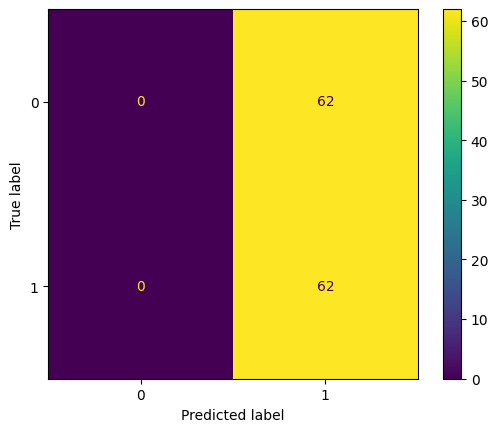

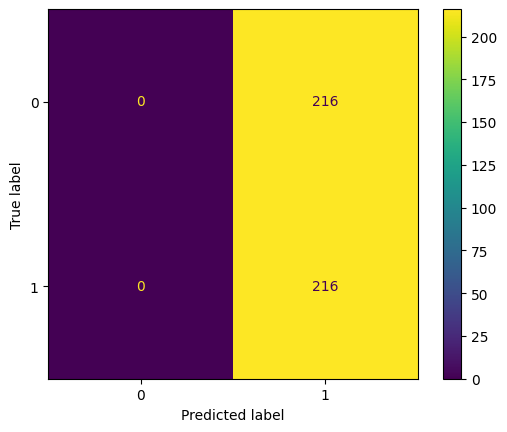

In [45]:
# Validation confusion matrix

predictions = lc.predict(X_train)
cm = confusion_matrix(y_train, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Model assessment

lc.score(X_test, y_test)
predictions = lc.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()